In [1]:
#Re1800:
import numpy as np
#from pylab import *
from scipy import special
import netCDF4 as nc

In [2]:
coarsePath= '/glade/work/adac/microHH/coarseData/'
coarse = nc.Dataset(coarsePath+'coarse4x2052_Re1800.nc', 'r')
uAll=np.array(coarse.variables['u'])
vAll=np.array(coarse.variables['v'])
bAll=np.array(coarse.variables['b'])

In [3]:
def shift_down(u,noslip=False,nzbuffer=3):
    utemp = u
    u[1:] = utemp[:-1]
    if noslip:
        u[0]=0.5*u[1] # interp with no slip
    else:
        u[0]=2*u[1]-u[2] # extrap else, e.g. for b
    for iz in range(-1,-nzbuffer,-1):
        u[iz]=u[-nzbuffer]
    
    return u

In [4]:
itimeInit = 0
noslip = False
u = shift_down(np.mean(uAll[:,:,:,itimeInit],axis=(1,2)),noslip)
v = shift_down(np.mean(vAll[:,:,:,itimeInit],axis=(1,2)),noslip)
b = shift_down(np.mean(bAll[:,:,:,itimeInit],axis=(1,2)),noslip)

In [5]:
# set the height
#kmax  = 3328
kmax = 64
zsize = 18.074844397670482
dz = zsize / kmax

In [6]:
z = np.linspace(0.5*dz, zsize-0.5*dz, kmax)

ug = np.zeros(kmax)
vg = np.zeros(kmax)
ug[:] = 0.049295030175465
vg[:] = 0.

# a_star = 5/8*zsize
# theta_ref = 300
# g         = 9.8
# dtheta_dz_z0 =0.028941114424258
# theta_z = np.zeros(kmax)
# theta_0 = 299.8649820802043

# visc = 0.000015
# fc   = 0.0001
# gamma = (fc / (2.*visc))**.5

# obtain theta_z and b for microhh
# for k in range(kmax):
#     theta_z[k]=a_star/2*(np.power(-np.pi/np.log(0.01),0.5))*dtheta_dz_z0*special.erf(z[k]/a_star/np.power(-np.log(0.01),-0.5))+theta_0
#     b[k]=g*(theta_z[k]-theta_ref)/theta_ref

# u[:] = ug[:]
# v[:] = vg[:]
# analytical solution as the starting profile to reduce run time
#for k in range(kmax):
#  u[k] = ug[k]*(1. - exp(-gamma*z[k]) * cos(gamma*z[k]))
#  v[k] = ug[k]*(     exp(-gamma*z[k]) * sin(gamma*z[k]))

# write the data to a file
#proffile = open('ekman.prof','w')
#proffile.write('{0:^20s} {1:^20s} {2:^20s} {3:^20s} {4:^20s} {5:^20s} {6:^20s}\n'.format('z','u','v','ug','vg','s','b'))
#for k in range(kmax):
#  proffile.write('{0:1.14E} {1:1.14E} {2:1.14E} {3:1.14E} {4:1.14E} {5:1.14E} {6:1.14E}\n'.format(z[k], u[k], v[k], ug[k], vg[k], s[k],b[k]))
#proffile.close()

In [7]:
float_type = 'f8'

nc_file = nc.Dataset("SBL1800_input.nc", mode="w", datamodel="NETCDF4", clobber=True)

nc_file.createDimension("z", kmax)
nc_z  = nc_file.createVariable("z" , float_type, ("z"))

nc_group_init = nc_file.createGroup("init");
nc_u = nc_group_init.createVariable("u", float_type, ("z"))
nc_v = nc_group_init.createVariable("v", float_type, ("z"))
nc_u_geo = nc_group_init.createVariable("u_geo", float_type, ("z"))
nc_v_geo = nc_group_init.createVariable("v_geo", float_type, ("z"))
nc_b = nc_group_init.createVariable("b", float_type, ("z"))

nc_z[:] = z[:]
nc_u[:] = u[:]
nc_v[:] = v[:]
nc_u_geo[:] = ug[:]
nc_v_geo[:] = vg[:]
nc_b[:] = b[:]

nc_file.close()

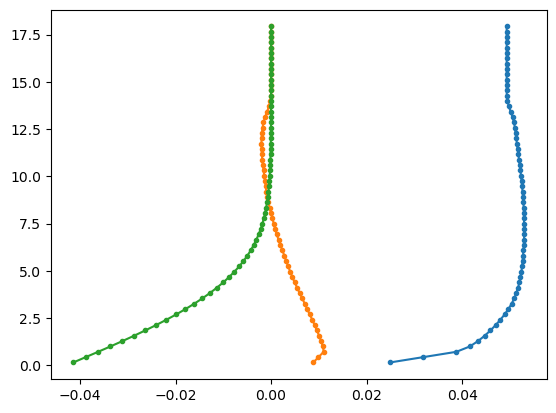

In [8]:
import matplotlib.pyplot as plt
plt.plot(u,z,'.-')
plt.plot(v,z,'.-')
plt.plot(10*b,z,'.-')